In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import random
from collections import Counter
import pickle
import PIL
import cv2
import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [2]:
device = "cpu"

In [3]:
images, labels = pickle.load(open('images_10_3.p', 'rb'))

In [4]:
# dataset class to create a data loader

class DDSM(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # images are in [0, 255] scale, normalize to [0, 1]
        image, label = self.images[idx]/255, self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image.float(), label

In [5]:
# define the image tranforms: 
# train: random flips and convert to tensor
# test: only convert to tensor
# resizing makes it large and does not fit into my GPU memory

val_list_transform = [transforms.ToTensor(),
                      # transforms.Resize(244),
                     ]

val_transform = transforms.Compose(val_list_transform)

In [6]:
model = torch.load("DDSM_5classes_adam_0.001.pt", map_location=device)

/home/masoud/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<AxesSubplot: >

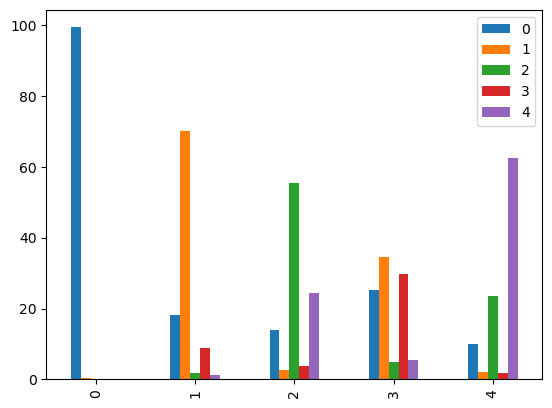

In [7]:
# create data loaders

batch_val = 16

test_dataset = DDSM(images, labels, val_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_val, shuffle=True)

res_dic = {str(i):{str(j): 0 for j in range(5)} for i in range(5)}
for im, lb in test_loader:
    output = model(im)
    preds = output.argmax(-1)
    for p, l in zip(preds, lb):
        res_dic[str(l.item())][str(p.item())] += 1
        
pd.DataFrame(res_dic).T.apply(lambda x: round(x/x.sum()*100, 2), axis=1).plot.bar()

In [147]:
class ModelWrapper(nn.Module):
    
    def __init__(self, model, layer):
        super().__init__()
        self.model = model
        self.layer = layer
        
        self.layer.register_backward_hook(self.hook_fn_bwd)
        self.layer.register_forward_hook(self.hook_fn_fwd)
    
        self.results_bwd = None
        self.results_fwd = None
    
    def hook_fn_bwd(self, *args):
        results_bwd = args[-1]
        self.results_bwd = results_bwd[0]
        
    def hook_fn_fwd(self, *args):
        self.results_fwd = args[-1]

    def get_forward(self):
        return self.results_fwd
    
    def get_grad(self):
        return self.results_bwd
    
    def forward(self, image):
        assert image.ndim==3, "Input should be a single image."
        return self.model(image[None])
    
    def grad_cam(self, image):
        pred = self(image).max()
        pred.backward(retain_graph=True)
        
        grad_cam = torch.zeros((self.results_bwd.size(2), self.results_bwd.size(3)))
        alphas = self.results_bwd[0].mean([1,2])
        
        alphas /= alphas.max()
        for i, alpha in enumerate(alphas):
            grad_cam += alpha * self.results_fwd[0][i]
        
        grad_cam = nn.functional.relu(grad_cam)
        grad_cam /= (grad_cam.max() + 0.01)
        grad_cam = grad_cam.detach()

        return cv2.resize(grad_cam.cpu().numpy(), (image.size(1), image.size(2)))

In [148]:
wrp_model = ModelWrapper(model, model.layer1)

In [149]:
inds = np.where((labels==1) | (labels==3))[0]

labels = labels[inds]
images = images[inds]

len(inds)

721

In [150]:
batch_val = 4

test_dataset = DDSM(images, labels, val_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_val, shuffle=True)

In [151]:
iter_loader = iter(test_loader)

In [166]:
im, lb = next(iter_loader)
lb, model(im).argmax(-1)

(tensor([1, 3, 1, 3]), tensor([1, 1, 0, 0]))

In [170]:
ind = 1
grad_cam = wrp_model.grad_cam(im[ind])

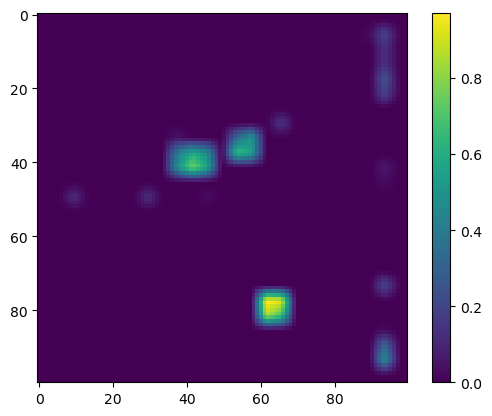

In [171]:
plt.imshow(grad_cam)
plt.colorbar()

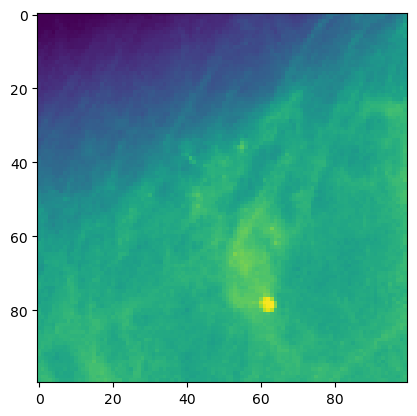

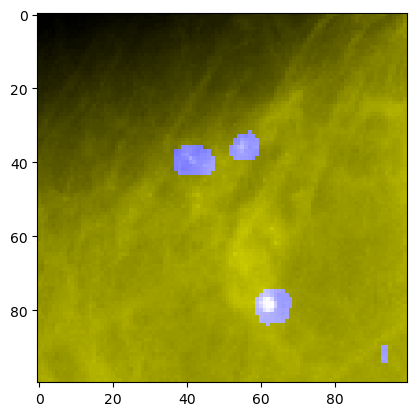

In [172]:
gim = im[ind].permute(1,2,0).numpy()[...,0]
gim = gim / gim.max()
plt.imshow(gim)
plt.figure()
gim = np.stack([gim, gim, grad_cam > 0.3], axis=2)
plt.imshow(gim)